# Neural ODE

System identification on a possibly sparse dataset of autonomous ODEs

In [33]:
import time
from tqdm import tqdm
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

In [34]:
%matplotlib widget

In [35]:
# data
nx = 2
dataset_size = 2_000 # number of sequences in the dataset
seq_len = 40 # length of each sequence (number of time steps, sampling time is irregular)

# model
width_size=64
depth=2

# optimization
batch_size = 32
lr = 1e-3
steps = 5_000

# logging
print_every = 100

In [36]:
seed = 1234
key = jr.PRNGKey(seed)
ykey, tkey1, tkey2, model_key, loader_key = jr.split(key, 5)

In [37]:
# generate 40 irregularly-spaced time series from the Lotka-Volterra model

y0 = 8*jr.uniform(ykey, (dataset_size, 2)) + 6

t0 = 0
t1 = 140 + jr.uniform(tkey1, (dataset_size,))
ts = jr.uniform(tkey2, (dataset_size, seq_len)) * (t1[:, None] - t0) + t0
ts = jnp.sort(ts)
dt0 = 0.1

def vector_field(t, y, args):
    prey, predator = y
    args = (0.1, 0.02, 0.4, 0.02)
    α, β, γ, δ = args
    d_prey = α * prey - β * prey * predator
    d_predator = -γ * predator + δ * prey * predator
    d_y = jnp.array([d_prey, d_predator])
    return d_y

def solve(ts, y0):
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(vector_field),
        diffrax.Tsit5(),
        ts[0],
        ts[-1],
        dt0,
        y0,
        saveat=diffrax.SaveAt(ts=ts),
    )
    return sol.ys

ys = jax.vmap(solve)(ts, y0)

ts.shape, ys.shape

((2000, 40), (2000, 40, 2))

In [38]:
# normalize data

mu = jnp.mean(jnp.mean(ys, axis=1), axis=0)#,
std = jnp.mean(jnp.std(ys, axis=1), axis=0)
ys = (ys - mu)/std

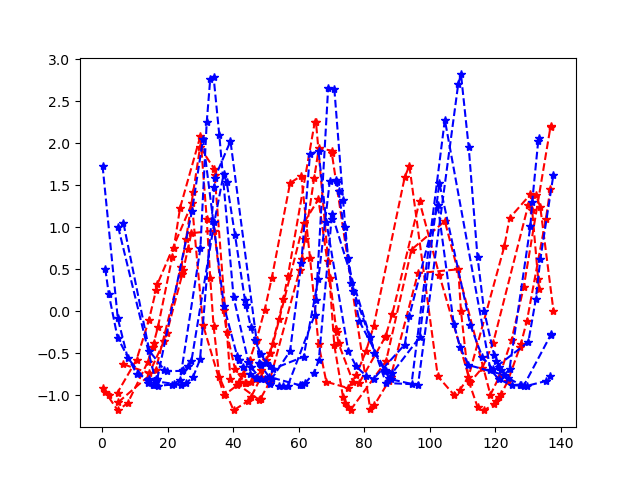

In [39]:
# plot some data
plt.figure()
plt.plot(ts[:4, :].T, ys[:4, :, 0].T, "r--*")
plt.plot(ts[:4, :].T, ys[:4, :, 1].T, "b--*");

In [40]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y) * 1e-3
    
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [41]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [42]:
model = NeuralODE(nx, width_size, depth, key=model_key)

In [43]:
optim = optax.adam(lr)
#optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

In [44]:
@eqx.filter_value_and_grad
def grad_loss(model, t, y):
    y_pred = jax.vmap(model)(t, y[:, 0])
    return jnp.mean((y - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [45]:
train_dl = dataloader((ts, ys), batch_size, key=loader_key)

In [46]:
LOSS = []
pbar = tqdm(enumerate(train_dl),  total=steps)
for step, (ts_batch, ys_batch) in pbar:
    loss, model, opt_state = make_step(ts_batch, ys_batch, model, opt_state)

    LOSS.append(loss)
    if (step % print_every) == 0 or step == steps - 1:
        pbar.set_postfix_str(f"Step: {step}, Loss: {loss}")
    if step == steps - 1:
        break
    

100%|█████████▉| 4999/5000 [02:33<00:00, 32.53it/s, Step: 4999, Loss: 0.06411834806203842] 


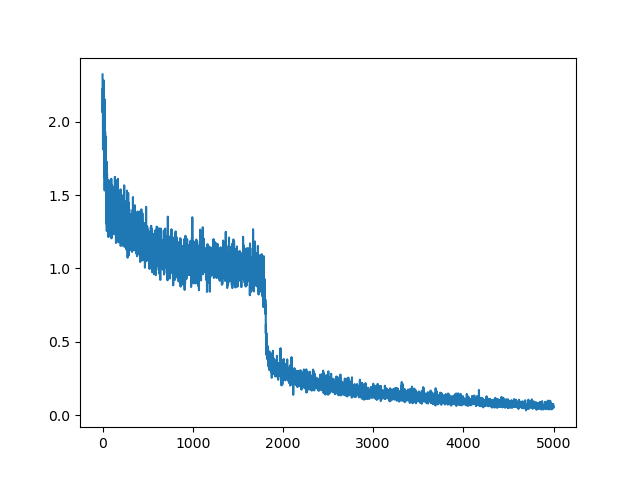

In [48]:
plt.figure()
plt.plot(LOSS)

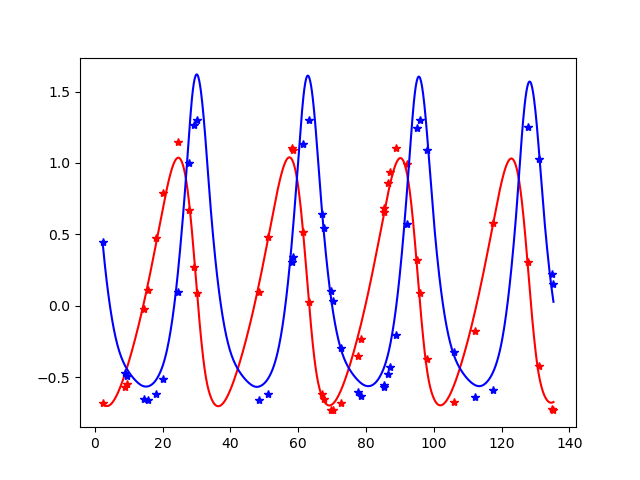

In [49]:
val_ts, val_ys = next(train_dl)
#jax.vmap(model)(val_ts, val_ys[:, 0])

def dense_grid(ts):
    return jnp.linspace(ts[0], ts[-1], 1000)

val_ts_dense = jax.vmap(dense_grid)(val_ts)
val_yhat_dense = jax.vmap(model)(val_ts_dense, val_ys[:, 0])

idx = 1
plt.figure()
plt.plot(val_ts[idx], val_ys[idx, :, 0], "r*")
plt.plot(val_ts_dense[idx], val_yhat_dense[idx, :, 0], "r")

plt.plot(val_ts[idx], val_ys[idx, :, 1], "b*")
plt.plot(val_ts_dense[idx], val_yhat_dense[idx, :, 1], "b")